In [1]:
using SymPy
using PyPlot
include("C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\src\\finiteDifferences.jl")
using FiniteDifferences

# Test the numerics against analytical solutions
Although there is no solution to the coupled equations, we are able to get analytical solutions to the steady state of the Smoluchowski equation and some solutions to the heat equation.

## Smoluchowski equation
The analytical steady state solution for the one dimensional Smoluchowski equation is:
$$ P_{ss}(x) = N \exp{\left(-\int_a^x \frac{V'(x')}{T(x')} dx' \right)} $$
In the case where the temperature is constant, this reduces to the Boltzmann density.
If we feed this probability density into stepP, then we should expect almost no change.

In [2]:
T0 = 3.0 # Temperature at the ends (i.e. bath temperature)

LL = 1.0
nPoints = 1000 # The number of points on the xAxis

lower = -10
upper = 10
xAxis = linspace(lower*LL, upper*LL, nPoints)
dx = (xAxis[end] - xAxis[1])/nPoints # Grid spacing

x = Sym("x")
V(x) = x^2  # A harmonic potetnial.
potential = Float64[V(x) for x in xAxis]
potential0, potentialEnd = V(xAxis[1] - dx), V(xAxis[end] + dx)
dV(s) = diff(V) |> replace(x, s)
dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)] |> float

tempFun(x) = 1.0
temperature = Float64[tempFun(x) for x in xAxis]

boltzmannDensity = exp(-potential./temperature)
boltzmannDensity = boltzmannDensity/discrete_quad(boltzmannDensity, xAxis[1], xAxis[end])

steadyState(x) = exp(-integrate(s -> dV(s)/tempFun(s), lower*LL, x))
steadyStateArray = Float64[steadyState(x) for x in xAxis]
steadyStateArray = steadyStateArray/discrete_quad(steadyStateArray, xAxis[1], xAxis[end])
P0 = steadyStateArray
density = P0;

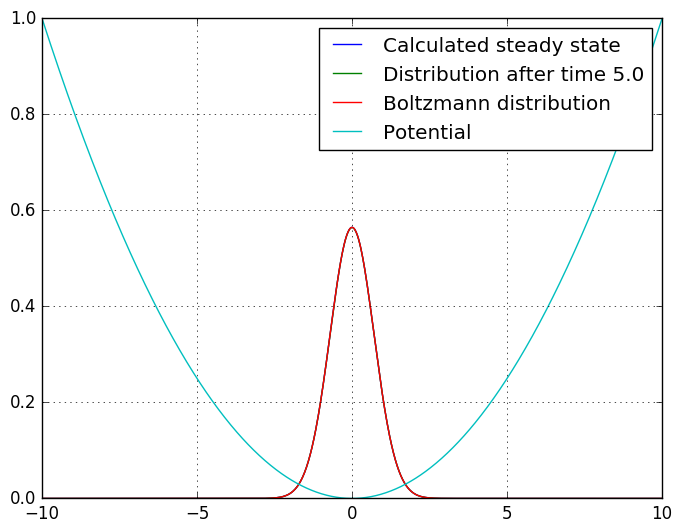

 10.585371 seconds (9.33 M allocations: 21.637 GB, 21.08% gc time)


(0.00287312452662247,1.5276160343097765e-14)

In [3]:
dt = 1e-4 # Size of the time step (keep this much smaller than the grid
          # spacing)
nSteps = 50000
@time begin
    for i = 2:nSteps
        density = stepP(density, dt, dpotential, temperature, xAxis, bndType = :absorbing, normalization = true)
    end
end
plot(xAxis, P0, xAxis, density, xAxis, boltzmannDensity, xAxis, 0.01potential)
legend(["Calculated steady state", "Distribution after time $(Float64(nSteps*dt))", "Boltzmann distribution", "Potential"])
grid()
norm(P0 - density), norm(P0 - boltzmannDensity)

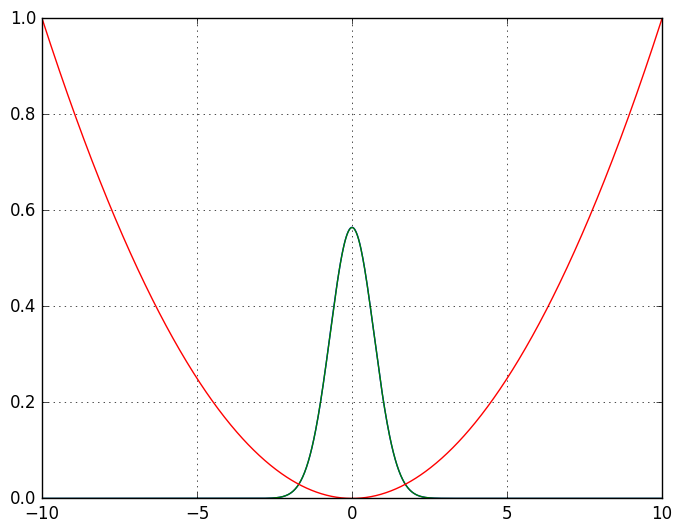

0.0006445478738794238

In [4]:
# Shifted version of the steady state.
density = Float64[steadyState(x - 1) for x in xAxis]

for i = 2:nSteps
    density = stepP(density, dt, dpotential, temperature, xAxis, bndType = :absorbing, normalization = true)
end

plot(xAxis, steadyStateArray, xAxis, density, xAxis, 0.01potential)
grid()
norm(steadyStateArray - density)/norm(steadyStateArray)

# Heat equation
First we will test the heat equation without the presence of a Brownian particle. In this case we have,
$$ \frac{\partial T}{\partial t} = \beta \frac{\partial^2 T}{\partial x^2} $$
the initial condition for the temperature will be denoted by,
$$ T(x, 0) = f(x) $$
and I will think of boundary conditions later...

Lets say that the boundaries are at $x = \pm 6$ and that the derivative of the temperature is zeros at the boudaries. The solution to the heat equation is given by:

$$ T(x, t) = \sum_{n=1}^\infty D_n \sin \left(\frac{n \pi x}{L} \right) \exp\left(\frac{-n^2 \pi^2 \beta t}{L^2}\right) $$
where
$$ D_n = \frac{2}{L} \int_0^L f(x) \sin \left(\frac{n \pi x}{L} \right) dx $$

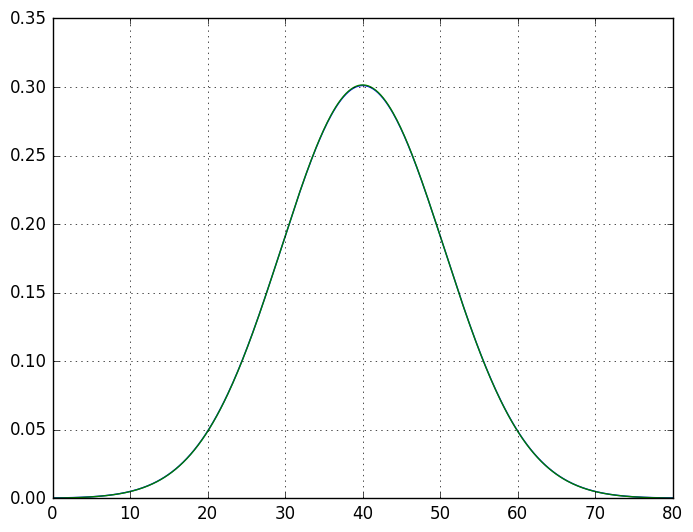

  0.264415 seconds (313.63 k allocations: 239.255 MB, 9.56% gc time)


0.0012061663231663021

In [5]:
T0 = 1.0
alpha = 1.0
beta = 5.0
LL = 80
dt = 1e-2 # Size of the time step (keep this much smaller than the grid
          # spacing)
nSteps = 1000
nPoints = 500
xAxis = linspace(0, LL, nPoints)

sigma = 0.1
tempFun(x) = exp(-(x-LL/2)^2/(4beta))

temperature = Float64[tempFun(x) for x in xAxis]
energy = (1/alpha)*discrete_quad(temperature, xAxis[1], xAxis[end])
temperature = temperature
totalTime = nSteps*dt

analyticalTemperature = Float64[(1/sqrt(totalTime + 1))*exp(-(x-LL/2)^2/(4beta*(totalTime + 1))) for x in xAxis]

dpotential = zeros(Float64, nPoints + 2)
potential = zeros(Float64, nPoints)
density = zeros(Float64, nPoints)
T = Array(Float64, nPoints, nSteps)
T[:, 1] = temperature
normalization = Array(Float64, nSteps)
normalization[1] = discrete_quad(temperature, xAxis[1], xAxis[end])
@time begin
    for i = 2:nSteps
        temperature = stepT(temperature, dt, density, potential,
        dpotential, alpha, beta, energy, xAxis; bndType=:neumann)
        normalization[i] = discrete_quad(temperature, xAxis[1], xAxis[end])
        T[:, i] = temperature
    end
end
plot(xAxis, temperature, xAxis, analyticalTemperature)
grid()
norm(temperature - analyticalTemperature)/norm(analyticalTemperature)

The difference between the numerical result and the analytical one is almost negligible.